<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Rllib_MultiAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [1]:
try:
  import clip
  from plot_image_grid import image_grid
  import ray
except ModuleNotFoundError:
  !pip install gym==0.21.0
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  !pip install ray
  !pip install lz4
  import clip
  from plot_image_grid import image_grid
  import ray

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'


!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

if not nb_path in os.environ['PYTHONPATH']:
  os.environ['PYTHONPATH'] += ':'+ nb_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [3]:
import pytorch3d
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [4]:
import copy

from pytorch3d.renderer import (
  HardPhongShader
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      # print(value, self._position)
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = copy.deepcopy(self._position)
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self._position = copy.deepcopy(self._prev_position)

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device
    

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 5.0, 7.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=256, 
              faces_per_pixel=1,
              bin_size=-1
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [5]:
from copy import deepcopy

from itertools import product

DIRECTIONS = list(product(range(-1, 2), repeat=3))
mod = 0.3
ALL_DIRECTIONS = [[a * mod for a in b] for b in DIRECTIONS]
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

CAMERA_CONFIG = {
  'azim': torch.linspace(0, 180, 4),
  'elev': [50],
  'dist': 20.0
}

GUIDE = "Pieces of fruit on top of a wooden table"

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'


def load_mesh(input_path) -> Meshes:

  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

def get_scene(objs, obs):
  objs = deepcopy(objs)
  for i, obj in enumerate(objs):
    obj.position = obs[i]
  scene = Scene([a.mesh for a in objs], **CAMERA_CONFIG)
  return scene.render(), scene.scene[0]

In [6]:
import gym
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.env.env_context import EnvContext
from PIL import Image
from scipy.stats import mannwhitneyu

LIMIT_BOX = [[-10,-1,-10],[10,10,10]]

class S2A(gym.Env):
  def __init__(self, obj, config: EnvContext = None):
    self.obj = obj
    self.cur_pos = np.asarray([0,0,0]).astype(np.float32)
    self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    self.observation_space = gym.spaces.Box(-12, 12, shape=(3,), dtype=np.float32)

  def reset(self):
    self.cur_pos = np.asarray([0,0,0]).astype(np.float32)
    self.obj.position = self.cur_pos
    return self.cur_pos

  def step(self, action):
    rw = 1
    action = ACTIONS_MAP[action]
    new_pos = [a+b for a,b in zip (self.cur_pos, action)]
    for i, val in enumerate(new_pos):
      if val < LIMIT_BOX[0][i] or val > LIMIT_BOX[1][i]:
        rw = 0
        new_pos[i] = self.cur_pos[i]
    self.cur_pos = new_pos
    self.obj.translate(action)
    return self.cur_pos, rw, False, {}

class BasicMultiAgent(MultiAgentEnv):
  """Env of N independent agents, each of which exits after limit steps."""

  def __init__(self, limit=None):
    super().__init__()
    fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

    fruit_object = SceneObject(fruit_mesh, scale=0.25)
    fruit_objectB = SceneObject(fruit_mesh, scale=0.25)
    table_object = SceneObject(table_mesh, scale=8)

    self.objs = [fruit_object,fruit_objectB, table_object]
    self.input_objs = deepcopy(self.objs)

    self.num = len(self.input_objs)
    self.agents = [S2A(self.input_objs[i]) for i in range(self.num)]
    self._agent_ids = set(range(self.num))
    self.dones = set()
    self.observation_space = gym.spaces.Box(-12, 12, shape=(3,), dtype=np.float32)
    self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    self.resetted = False
    self.best_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_sim_matrix = np.zeros(4).astype(np.float32)
    self.best_obs = {}
    self.model, self.preprocess = self.clip_model()
    self.limit = limit
    self.rounds = 0

  def clip_model(self):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.cuda().eval()
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    return model, preprocess

  def get_pil_image(self, input):
    return Image.fromarray((input * 255).astype('uint8'))

  def clip_sim_3(self, input: list, description: str):
    text = clip.tokenize(description).to(device)
    with torch.no_grad():
      text_features = self.model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = []
    for image_input in input:
      # image_input = get_pil_image(image_input[0, ..., :3])
      image_input = self.preprocess(image_input).unsqueeze(0).to(device)

      with torch.no_grad():
        image_features = self.model.encode_image(image_input).float()

      image_features /= image_features.norm(dim=-1, keepdim=True)
      similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
      # print(similarity[0][0])
      similarities.append(similarity[0][0])
    return similarities

  def perform_test(self, a, b):
    stat, p = mannwhitneyu(a, b, alternative='greater',method='exact')
    return stat, p

  def render_scene_and_score(self, in_objs):
    scene_input = [obj.mesh for obj in in_objs]
    scene = Scene(scene_input, **CAMERA_CONFIG)
    images = scene.render()
    pil_images = [self.get_pil_image(img[..., :3]) for img in images]
    return self.clip_sim_3(pil_images, GUIDE)

  def get_reward(self, sim_matrix) -> int:
    rw = 0

    stat_best, p_best = self.perform_test(sim_matrix, self.best_sim_matrix)
    stat_prev, p_prev = self.perform_test(sim_matrix, self.prev_sim_matrix)

    if p_best <= 0.1:
      self.best_sim_matrix = sim_matrix
      self.best_obs = {a: b.position for a,b in zip(self._agent_ids, self.input_objs)}

    rw += 1-p_best
    rw += 1-p_prev

    rw = (2 *(rw - -2)/(2- -2)) - 1

    self.prev_sim_matrix = sim_matrix

    return rw

  def reset(self):
    self.input_objs = deepcopy(self.objs)
    self.agents = [S2A(self.input_objs[i]) for i in range(self.num)]
    self.best_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_sim_matrix = np.zeros(4).astype(np.float32)
    self.best_obs = {}
    self.resetted = True
    self.dones = set()
    return {i: a.reset() for i, a in enumerate(self.agents)}

  def step(self, action_dict):
    self.rounds += 1
    obs, rew, done, info = {}, {}, {}, {}

    for i, action in action_dict.items():
      obs[i], rew[i], done[i], info[i] = self.agents[i].step(action)

    score = self.render_scene_and_score(self.input_objs)
    reward = self.get_reward(score)

    for i in range(len(action_dict.items())):
      rew[i] = rew[i] * reward

    done['__all__'] = False
    if isinstance(self.limit, int):
      if self.rounds >= self.limit:
        done = {i: True for i in range(len(self.agents))}
        done['__all__'] = True
    return obs, rew, done, info


In [37]:
basic_multi_agent = BasicMultiAgent(20)

In [ ]:
obs = basic_multi_agent.reset()

# for i in range(basic_multi_agent.limit):
for i in range(30):
  obs, rew, done, info = basic_multi_agent.step({i: basic_multi_agent.action_space.sample() for i in range(len(basic_multi_agent.input_objs))})
  print(rew)
  if all(done):
    break

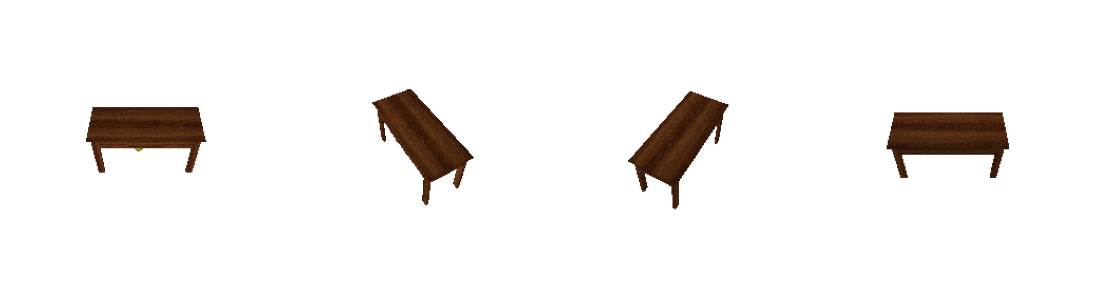

In [11]:
images, scene = get_scene(basic_multi_agent.input_objs, basic_multi_agent.best_obs)
image_grid(images, rows=1, cols=4, rgb=True)

In [ ]:
plot_batch_individually(scene)

In [7]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True)

RayContext(dashboard_url='', python_version='3.7.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-21_11-25-01_671985_3518/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-21_11-25-01_671985_3518/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-08-21_11-25-01_671985_3518', 'metrics_export_port': 50882, 'gcs_address': '172.28.0.2:63729', 'address': '172.28.0.2:63729', 'node_id': 'a8cd485e8c64ccb14532cfc3a335720408623bf1a14db6576cab7b69'})

In [8]:
from ray.tune.registry import register_env

def env_creator(args):
  return BasicMultiAgent()

# env = env_creator({})
register_env("clip_guided", env_creator)

In [9]:
import ray.rllib.agents.dqn as dqn

config = dqn.DEFAULT_CONFIG.copy()

In [62]:
config

{'num_workers': 0,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 4,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 32,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  '_disable_action_flattening': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  '

In [10]:
from ray.rllib.agents.dqn import DQNTrainer as DQN

dqn_agent = DQN(
    env="clip_guided",
    config={
        'num_atoms': 10,
        'v_max': 100,
        'v_min': -100,
        "num_workers": 0,
        "num_gpus": 1,
        'hiddens': [512],
        "gamma": 0.95,
        "n_step": 1,
        "framework": "torch",
        "noisy": True,
        'grad_clip': 4,
        'timesteps_per_iteration': 1000,
        'horizon': 100
    },
)

2022-08-21 11:26:42,351	INFO logger.py:188 -- pip install "ray[tune]" to see TensorBoard files.
2022-08-21 11:26:42,353	WARNING logger.py:337 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2022-08-21 11:26:42,360	INFO simple_q.py:188 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-08-21 11:26:42,362	INFO trainer.py:906 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-08-21 11:26:50,375	WARNING multi_agent_env.py:225 -- observation_space_sample() has not been implemented
2022-08-21 11:26:50,572	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-21 11:26:50,574	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-21 11:26:50,576	WARNING multi_agent_env.py:137 -- observation_space_contains() ha

In [11]:
result = dqn_agent.train()

2022-08-21 11:27:00,424	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `RepayBuffer.add()` instead. This will raise an error in the future!
2022-08-21 11:27:00,447	WARNING multi_agent_prioritized_replay_buffer.py:187 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
2022-08-21 11:27:00,450	WARNING deprecation.py:47 -- DeprecationWarning: `replay` has been deprecated. Use `sample` instead. This will raise an error in the future!
/usr/local/lib/python3.7/dist-packages/ray/rllib/agents/dqn/dqn_torch_model.py:146: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  action_scores = self.advantage_module(model_out)


In [23]:
result

{'custom_metrics': {},
 'episode_media': {},
 'info': {'learner': {'default_policy': {'custom_metrics': {},
    'learner_stats': {'cur_lr': 0.0005},
    'model': {},
    'td_error': array([2.3490336, 2.3016176, 2.3048148, 2.3027475, 2.302171 , 2.3023806,
           2.3023612, 2.302288 , 2.3018205, 2.301528 , 2.4415164, 2.3055475,
           2.3376322, 2.302216 , 2.3140647, 2.3581526, 2.301518 , 2.3027475,
           2.3020585, 2.422962 , 2.302616 , 2.3013277, 2.3755405, 2.3023767,
           2.3023746, 2.301394 , 2.30586  , 2.300561 , 2.3035908, 2.3035867,
           2.3021848, 2.3028007], dtype=float32),
    'mean_td_error': 2.317605972290039}},
  'num_env_steps_sampled': 1008,
  'num_env_steps_trained': 32,
  'num_agent_steps_sampled': 1008,
  'num_agent_steps_trained': 32,
  'last_target_update_ts': 1008,
  'num_target_updates': 1},
 'sampler_results': {'episode_reward_max': 130.28571428571425,
  'episode_reward_min': 105.42857142857159,
  'episode_reward_mean': 115.56904761904768,


In [ ]:
# import ray.rllib.agents.ppo as ppo

# config = ppo.DEFAULT_CONFIG.copy()
# config.update({
#   "num_workers": 0,
#   "num_gpus": 1,
#   "train_batch_size": 150,
#   "sgd_minibatch_size": 10,
#   "model": {
#       "vf_share_layers": True,
#   },
#   "horizon": 50
# })

# trainer = ppo.PPOTrainer(config, env='clip_guided')

In [ ]:
# N_ITER = 10
# s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} explained var {:6.2f} loss {:6.2f} episodes total {:6.2f} saved {}"

# for n in range(N_ITER):
#   result = trainer.train()
#   file_name = trainer.save(f"{nb_path}/tmpray/")
#   smplr_res = result["sampler_results"]
#   lrn_stat = result["info"]["learner"]["default_policy"]["learner_stats"]
#   print(s.format(
#     n + 1,
#     result["episode_reward_min"],
#     result["episode_reward_mean"],
#     result["episode_reward_max"],
#     result["episode_len_mean"],
#     lrn_stat["vf_explained_var"],
#     lrn_stat["vf_loss"],
#     result["episodes_total"],
#     file_name
#   ))


In [13]:
from torch import cuda
cuda.empty_cache()

In [14]:
test_env = BasicMultiAgent()

In [21]:
obs = test_env.reset()

for i in range(100):
  action = {}
  for agent_id, agent_obs in obs.items():
      action[agent_id] = dqn_agent.compute_action(agent_obs, policy_id='default_policy')
  obs, reward, done, info = test_env.step(action)
  if all(done):
    break

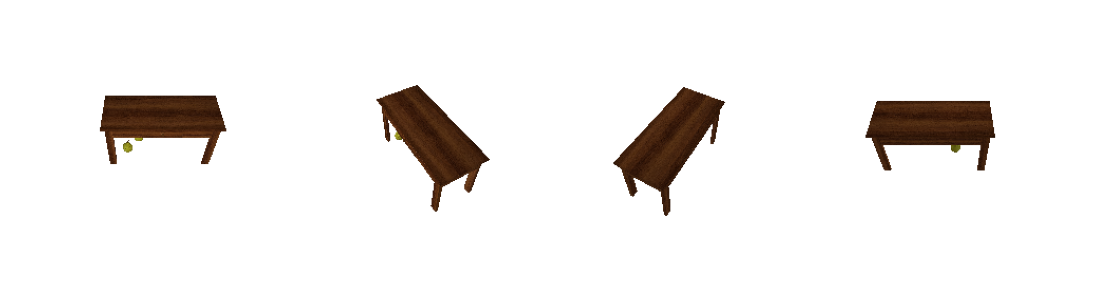

In [22]:
images, scene = get_scene(test_env.input_objs, test_env.best_obs)
image_grid(images, rows=1, cols=4, rgb=True)

In [75]:
plot_batch_individually(scene)

In [ ]:
# from ray import tune

# tune.run(
#     "PPO",
#     checkpoint_freq=120,
#     config={
#         "env": "clip_guided",
#         "lambda": 0.95,
#         "kl_coeff": 0.5,
#         "clip_rewards": True,
#         "clip_param": 0.2,
#         "vf_clip_param": 10.0,
#         "entropy_coeff": 0.01,
#         "train_batch_size": 32,
#         "sgd_minibatch_size": 6,
#         "num_workers": 0,
#         "num_envs_per_worker": 1,
#         "lr": 1e-4,
#         "gamma": 0.9,
#         "batch_mode": "complete_episodes",
#         "observation_filter": "NoFilter",
#         "num_gpus": 1,
#         "model": {
#             "fcnet_activation": "relu",
#             "fcnet_hiddens": [32, 32],
#         },
#         "timesteps_per_iteration": 12
#     }
# )